In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
heartData = pd.read_csv("heart-failure-prediction/heart.csv")
heartData.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
heartData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
heartData.dropna()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [5]:
heartData.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
heartData = heartData[(heartData["Cholesterol"] != 0) & (heartData["RestingBP"] != 0) & (heartData["Sex"] != "F")]

In [7]:
heartData.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000
mean,53.102837,133.359929,241.040780,0.187943,138.040780,0.978191,0.560284
std,9.556603,16.842386,57.509194,0.391014,24.922903,1.096840,0.496793
min,28.000000,92.000000,85.000000,0.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,206.750000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,234.000000,0.000000,139.500000,0.800000,1.000000
75%,59.000000,140.000000,272.250000,0.000000,156.000000,1.800000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000


In [8]:
heartData.shape

(564, 12)

In [9]:
heartData.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0


In [10]:
from sklearn.preprocessing import StandardScaler

#Standardisierung
features = ["RestingBP", "Cholesterol"]

# Separating out the features
x = heartData.loc[:, features].values

# Separating out the target
y = heartData.loc[:,["HeartDisease"]].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [12]:
finalDf = pd.concat([principalDf, heartData[["HeartDisease"]]], axis = 1)

In [13]:
finalDf.head()

,principal component 1,principal component 2,HeartDisease
0,0.869231,-0.311185,0.0
1,0.375182,-0.657557,NaN
2,0.132634,1.265832,0.0
3,0.644133,-1.766929,NaN
4,-1.388223,-0.574993,0.0


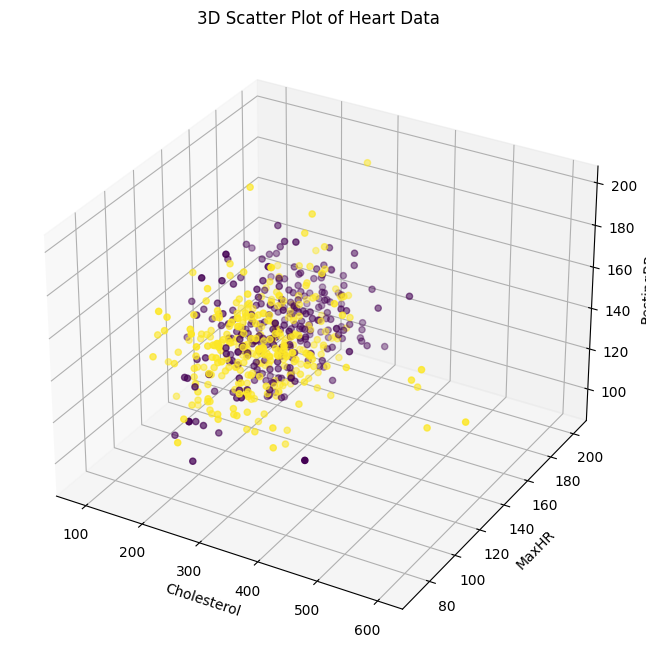

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming heartData is your DataFrame containing the data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(heartData["Cholesterol"], heartData["MaxHR"], heartData["RestingBP"], c=heartData["HeartDisease"])

# Labels
ax.set_xlabel('Cholesterol')
ax.set_ylabel('MaxHR')
ax.set_zlabel('RestingBP')
ax.set_title('3D Scatter Plot of Heart Data')

plt.show()

C:\Users\Oleg\AppData\Local\Temp\ipykernel_44016\3932195900.py:32: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pca_df[pca_df['HeartDisease'] == 0]['Age'],
C:\Users\Oleg\AppData\Local\Temp\ipykernel_44016\3932195900.py:37: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pca_df[pca_df['HeartDisease'] == 1]['Age'],


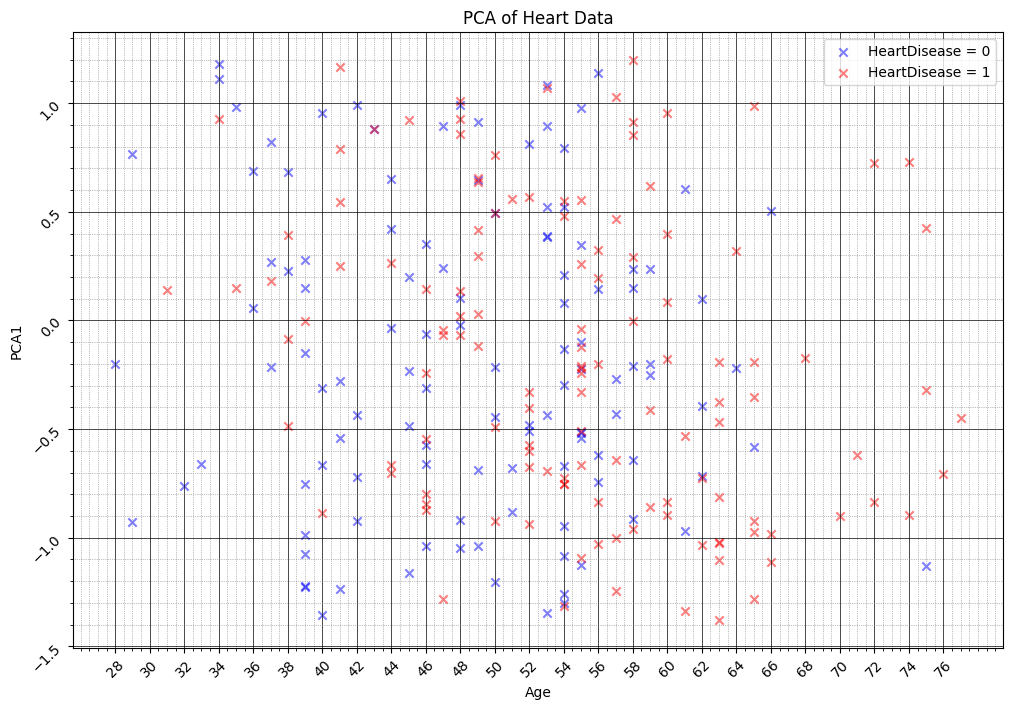

,PCA1,Age,HeartDisease
count,446.000000,244.000000,244.000000
mean,-0.114335,51.786885,0.520492
std,0.694661,9.706160,0.500607
min,-1.389233,28.000000,0.000000
25%,-0.693967,46.000000,0.000000
50%,-0.190039,53.000000,1.000000
75%,0.465405,58.000000,1.000000
max,1.197364,77.000000,1.000000


In [15]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Extrahieren der relevanten Daten
X = heartData[['Cholesterol', 'MaxHR', 'RestingBP']]
age = heartData['Age']
heart_disease = heartData['HeartDisease']

# Standardisierung der Daten
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# PCA durchführen
pca = PCA(n_components=1)
pca_results = pca.fit_transform(X_standardized)

# Ergebnis als DataFrame
pca_df = pd.DataFrame(data=pca_results, columns=['PCA1'])
pca_df = pca_df[(pca_df['PCA1'] >= -1.4) & (pca_df['PCA1'] <= 1.2)]
pca_df['Age'] = age
pca_df['HeartDisease'] = heart_disease

# Visualisierung
plt.figure(figsize=(12, 8))

#plt.xlim(54, 56)
#plt.ylim(-0.5, 0)

# Scatter plot für HeartDisease == 0 (blau)
plt.scatter(pca_df[pca_df['HeartDisease'] == 0]['Age'], 
            pca_df[pca_df['HeartDisease'] == 0]['PCA1'], 
            alpha=0.5, c='b', edgecolors='k', label='HeartDisease = 0',marker="x",)

# Scatter plot für HeartDisease == 1 (rot)
plt.scatter(pca_df[pca_df['HeartDisease'] == 1]['Age'], 
            pca_df[pca_df['HeartDisease'] == 1]['PCA1'], 
            alpha=0.5, c='r', edgecolors='k', label='HeartDisease = 1',marker="x",)

plt.title('PCA of Heart Data')
plt.xlabel('Age')
plt.ylabel('PCA1')
plt.grid(True)
plt.legend()

# Achsen anpassen und detaillierter anzeigen
plt.xticks(range(int(pca_df['Age'].min()), int(pca_df['Age'].max())+1, 2), rotation=45)
plt.yticks(rotation=45)

# Gitterlinien hinzufügen
plt.minorticks_on()
plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')

plt.show()

# Statistische Beschreibung der Ergebnisse
pca_df.describe()